# Большое практическое задание 2

# Применение линейных моделей для определения токсичности комментария

## курс "Машинное обучение 1", программа OzonMasters, 2021

## Студент: Быкова Ульяна Игоревна

## Формулировка задания
Данное задание направлено на ознакомление с линейными моделями и градиентными методами обучения. В
задании необходимо: <br>
1. Написать на языке Python собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит-тесты и с помощью системы ejudge в соответствующем соревновании. <br><br> **Внимание.** Прохождение всех тестов в соревновании не гарантирует правильность решения. 


2. Вывести все необходимые формулы, привести выкладки в отчёте. 


3. Провести описанные ниже эксперименты с модельными данными и приложенным датасетом в данном ноутбуке. Подготовить отчёт о проделанной работе. Удалите черновые выводы, оставьте только тот код, который является ответом к пунктам задания. Сохраните ноутбук в форматах .ipynb и .html одновременно. <br><br> **Замечание.** Чтобы экспорировать jupyter notebook в .html нужно выбрать: `File -> Download as -> HTML (.html)`. Для экспорта notebook в .html в Google Colab, воспользуйтесь [следующим кодом](https://gist.github.com/vbugaevskii/b9c6181f2ad83e11f5b9c92d315cb2de). Большая просьба: подписывайте свой отчет (в названии файла и внутри ноутбука).


4. В систему проверки необходимо сдать отчёт в обоих форматах и .zip архив с написанными модулями. <br><br> Большая просьба: jupyter notebook и html файл не запаковывать в архив, а сдавать отдельно.


### Некоторые полезные советы
1. Для того, чтобы не перезагружать jupyter notebook каждый раз после того, как вы внесли изменения в модуль knn, можно добавить ячейку с таким содержимым:
```python
%load_ext autoreload
%autoreload 2
```


2. Не нужно копировать свой код из модулей в jupyter notebook, пользуйтесь им, как если бы это была библиотека. Для этого поместите директорию `modules` рядом с notebook-ом. Пример, как может выглядеть содержимое вашей рабочей директории:
```text
tree
    ---modules
    ------__init__.py
    ------linear_model.py
    ------losses.py
    ------utils.py
    ------tests.py
    ------tests_bouns.py
    HW2_*.ipynb
```

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии.

$$L(a(x), y) = \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\}$$

Запишите вывод градиента ниже.

Производная сложной функции

$$dL(a(x), y)/dw = \frac{d(1 + \exp(-y\langle w, x\rangle))/dw}{1 + \exp(-y\langle w, x\rangle)} = 
\frac{\exp(-y\langle w, x\rangle) * d(-y\langle w, x\rangle)/dw}{1 + \exp(-y\langle w, x\rangle)} = 
\frac{\exp(-y\langle w, x\rangle) * (-y*x)}{1 + \exp(-y\langle w, x\rangle)} = \frac{-y*x}{\frac{1}{\exp(-y\langle w, x\rangle)} + 1} =\\= \frac{-y*x}{\exp(y\langle w, x\rangle) + 1}$$

## Реализация алгоритмов (9 баллов)
Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить все
тесты. Задание, не проходящее все тесты, приравнивается к невыполненному. 


При написании необходимо пользоваться стандартными средствами языка Python, библиотеками `numpy, scipy и matplotlib`. Библиотекой `scikit-learn` для реализаций пользоваться запрещается, но разрешается использовать её в процессе экспериментов. Все
подробности реализации алгоритмов подробно описаны в [спецификации](https://drive.google.com/file/d/1cby1SXsS0TkeFd-3AkE2j1JhKYU9Er1N/view) к заданию.


Ожидается, что реализациия всех классов и функций будет максимально эффективной. Дополнительно вам предоставлены открытые тесты, которые находятся в модуле `modules`. Чтобы запустить тесты в консоли требуется выполнить команду:
```c
$ pytest ./modules/tests.py

```

Разрешается дополнять файл тестами для самопроверки. Доп баллы за написание своих тестов не будет :)


## Предобработка данных (2 балла)
Импортируйте все, что вам потребуется для экспериментов:

In [112]:
from functools import lru_cache
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pymorphy2
import re
import scipy
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss, MultinomialLoss
from modules.utils import get_numeric_grad, compute_balanced_accuracy

### 1. Загрузка даннных
Эксперименты этого задания необходимо проводить на датасете, содержащим комментарии из раздела обсуждений английской Википедии, который был преобразован для решения задачи бинарной классификации: является ли данный комментарий токсичным или нет. Подробнее об исходных данных [здесь](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Требуемый для выполнения данного задания датасет можно найти по следующей [ссылке](https://drive.google.com/file/d/1FLTAFR29Koi4YDkLUdVQWNabnBQCTFbn/view). 


Данные в датасете записаны в формате `csv`. Для базовой части экспериментов используйте в качестве целевой переменной столбец `is_toxic`. Обратите внимание на метки классов в датасете, замените их на те, которые ожидает увидеть на вход ваша реализация `LinearModel`.

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.is_toxic.unique()

array([0, 1])

In [6]:
train['is_toxic'] = train['is_toxic'].map({0:-1, 1:1})

In [177]:
test['is_toxic'] = test['is_toxic'].map({0:-1, 1:1})

### 2. Предобработка текста
Произведите предварительную обработку текста. Приведите все тексты к нижнему регистру. Замените в тексте все символы, не являющиеся буквами и цифрами, на пробелы. Примените алгоритм лемматизации (например, `WordNetLemmatizer` из библотеки `nltk`) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из `nltk`).

**Замечание.** Полезные функции: `str.lower, str.split, str.isalnum, re.sub, re.split`.

In [8]:
nltk.download('stopwords')

stopwords = set(stopwords.words('english'))
en_lemmatizer = pymorphy2.MorphAnalyzer()
en_stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /home/uliana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# from sem_9 file

class Preprocesser:
    def __init__(self, stopwords):
        self.bad_symbol_regexp = re.compile('[^а-яёa-z0-9\s]')
        en_lemmatizer = pymorphy2.MorphAnalyzer()
        @lru_cache(maxsize=10 ** 6)
        def lru_lemmatizer(word):
            return en_lemmatizer.parse(word)[0].normal_form
        self.lemmatizer = lru_lemmatizer
        self.stopwords = stopwords
        
    def __call__(self, text):
        text = text.lower()
        text = re.sub(self.bad_symbol_regexp, ' ', text)
        text = re.sub('\s+', ' ', text)
        lemmas = [
            self.lemmatizer(token)
            for token in text.split()
        ]
        lemmas = [
            token
            for token in lemmas
            if token not in self.stopwords
        ]
        
        return ' '.join(lemmas)

In [10]:
preprocess_text = Preprocesser(stopwords=stopwords)

In [11]:
train['preprocessed_text'] = train['comment_text'].apply(preprocess_text)
test['preprocessed_text'] = test['comment_text'].apply(preprocess_text)

In [12]:
train.drop('comment_text', axis=1, inplace=True)
test.drop('comment_text', axis=1, inplace=True)

### 3. Train/val
Разделите данные на обучение и валидацию. Для валидации выберете $30\%$ случайных объектов из датасета. Рекомендуется использовать функцию `sklearn.model_selection.train_test_split`.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('is_toxic', axis=1), train['is_toxic'], 
                                                  test_size=0.3, random_state=42,
                                                  stratify=train['is_toxic'])

### 4. Tf-idf
Преобразуйте текст в разреженную матрицу `scipy.sparse.csr_matrix`, где значение $x$ в позиции $(i, j)$ сответствует tf-idf характеристке $j$-го слова в $i$-ом документе. Рекомендуется использовать конструктор `sklearn.feature_extraction.text.TfidfVectorizer`. Добавьте в данные единичный столбец на **нулевой** позиции.

**Замечание 1.** У `TfidfVectorizer` есть несколько методов для работы, используйте `fit_transform` и `fit` для обучающей выборки, используйте `transform` для тестовой.


**Замечание 2.** Используйте параметр `min_df`, чтобы уменьшить размерность данных и ускорить проведение экспериментов. Рекомендуется использовать `min_df` не меньше $5$.


**Замечание 3.** Для добавления единичного столбца, можно воспользоваться следующей инструкцией:
```python
from scipy.sparse import hstack, csr_matrix
X = csr_matrix(hstack([csr_matrix(np.ones((X.shape[0], 1))), X]))
```

In [14]:
tfidf_vectorizer = TfidfVectorizer(min_df=7, max_df=0.99, ngram_range=(1, 2))
X = dict()
X['train'] = tfidf_vectorizer.fit_transform(X_train['preprocessed_text'])
X['valid'] = tfidf_vectorizer.transform(X_val['preprocessed_text'])
X['test'] = tfidf_vectorizer.transform(test['preprocessed_text'])

In [15]:
X['train'] = csr_matrix(hstack([csr_matrix(np.ones((X['train'].shape[0], 1))), X['train']]))
X['valid'] = csr_matrix(hstack([csr_matrix(np.ones((X['valid'].shape[0], 1))), X['valid']]))
X['test'] = csr_matrix(hstack([csr_matrix(np.ones((X['test'].shape[0], 1))), X['test']]))

y = {'train':y_train.values, 'valid':y_val.values, 'test':test['is_toxic'].values}

#### Ответьте на следующие вопросы

1. Поясните, почему мы хотим хранить данные в разреженных матрицах CSR формата? Почему для данной задачи этот формат подходит лучше DOK формата (словарь, где ключ это пара (строка, столбец), а значение это соответствующий строке и столбцу элемент матрицы)?

    Заполненность таблицы данными для подобных задач (когда мы векторизуем тексты) невелика, особенно если будем брать n-граммы. Каждый новый текст/комментарий раздувает таблицу. В итоге если хранить данные в обычной таблице, очень много места в памяти будет использоваться неэффективно.
    Разреженная матрица CSR формата удобнее, так как 1) мы уже написали модули с использованием разреженных матриц 2) можно обрабатывать матрицы такого вида встроенными быстрыми функциями из scipy (что мы, собственно, и реализовали в модулях)

## Эксперименты (13 баллов)

### 1. Исследование параметров градиентного спуска (3 балла)

В спецификации предлагается использовать следующую формулу для выбора темпа обучения $\eta_k$:


$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $\alpha$, $\beta$ - заданные константы}, \; \text{$k$ - номер итерации}$$


Исследуйте поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`

Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода

В качестве метрики качества здесь и далее предлагается использовать сбалансированную точность (balanced accuracy), реализацию, совместимую с множеством меток $\{−1, 1\}$, можно найти в модуле `utils`.


**Замечание.** Для оценки времени долго работающих функций можно пользоваться либо функциями из модуля `time`, либо magic-командой `%time`, которая запускает код лишь один раз.


In [64]:
a = np.arange(0, 1.01, 0.2)
b = np.arange(0, 1.01, 0.2)

In [65]:
d_accs = {}

In [66]:
for alpha in a:
    d_accs[f'alpha_{alpha}'] = {}
    for beta in tqdm(b):
        lm = LinearModel(BinaryLogisticLoss(l2_coef=1), step_alpha=alpha, step_beta=beta)
        hist = lm.fit(X['train'], y['train'], trace=True, X_val=X['valid'], y_val=y['valid'])
        func = min(hist['func'])
        func_val = min(hist['func_val'])
        epoch = np.argmin(hist['func_val'])
        func_time = sum(hist['time'][:epoch])
        threshold = lm.get_optimal_threshold(X['valid'], y['valid'])
        y_pred = lm.predict(X['valid'], threshold)
        d_accs[f'alpha_{alpha}'][f'beta_{beta}'] = {'acc':compute_balanced_accuracy(y['valid'], y_pred), 
                                                    'func':func, 'func_val':func_val, 'pair_time':func_time,
                                                    'epoch':epoch}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.45s/it]


#### Приведите график / таблицу с результатами ваших экспериментов

In [67]:
cm = sns.light_palette('green', as_cmap=True)

In [71]:
# зависимость значения функции потерь от реального времени работы метода

d_loss_ep = {}
for a in d_accs:
    for b in d_accs[a]:
        d_loss_ep[f'{a[:9]}_{b[:8]}'] = {}
        d_loss_ep[f'{a[:9]}_{b[:8]}']['func_val'] = d_accs[a][b]['func_val']
        d_loss_ep[f'{a[:9]}_{b[:8]}']['pair_time'] = d_accs[a][b]['pair_time']
pd.DataFrame(d_loss_ep).T.sort_index().style.background_gradient(cmap=cm)

,func_val,pair_time
alpha_0.0_beta_0.0,23014.750232,0.000000
alpha_0.0_beta_0.2,23014.750232,0.000000
alpha_0.0_beta_0.4,23014.750232,0.000000
alpha_0.0_beta_0.6,23014.750232,0.000000
alpha_0.0_beta_0.8,23014.750232,0.000000
alpha_0.0_beta_1.0,23014.750232,0.000000
alpha_0.2_beta_0.0,0.329942,10.165442
alpha_0.2_beta_0.2,0.336487,11.867121
alpha_0.2_beta_0.4,0.370769,10.852461
alpha_0.2_beta_0.6,0.436775,13.321105


In [72]:
# зависимость значения функции потерь от эпохи метода

d_loss_ep = {}
for a in d_accs:
    for b in d_accs[a]:
        d_loss_ep[f'{a[:9]}_{b[:8]}'] = {}
        d_loss_ep[f'{a[:9]}_{b[:8]}']['func_val'] = d_accs[a][b]['func_val']
        d_loss_ep[f'{a[:9]}_{b[:8]}']['epoch'] = d_accs[a][b]['epoch']
pd.DataFrame(d_loss_ep).T.sort_index().style.background_gradient(cmap=cm)

,func_val,epoch
alpha_0.0_beta_0.0,23014.750232,0.000000
alpha_0.0_beta_0.2,23014.750232,0.000000
alpha_0.0_beta_0.4,23014.750232,0.000000
alpha_0.0_beta_0.6,23014.750232,0.000000
alpha_0.0_beta_0.8,23014.750232,0.000000
alpha_0.0_beta_1.0,23014.750232,0.000000
alpha_0.2_beta_0.0,0.329942,106.000000
alpha_0.2_beta_0.2,0.336487,135.000000
alpha_0.2_beta_0.4,0.370769,125.000000
alpha_0.2_beta_0.6,0.436775,151.000000


In [77]:
# значение метрики качества после обучения метода

d_ac = {}
for a in d_accs:
    d_ac[a[:9]] = {}
    for b in d_accs[a]:
         d_ac[a[:9]][b[:8]] = d_accs[a][b]['acc']
pd.DataFrame(d_ac)[sorted(d_ac.keys())].style.background_gradient(cmap=cm, axis=None)

,alpha_0.0,alpha_0.2,alpha_0.4,alpha_0.6,alpha_0.8,alpha_1.0
beta_0.0,0.500000,0.849386,0.860111,0.863217,0.864372,0.500000
beta_0.2,0.500000,0.815895,0.844094,0.853515,0.858653,0.860800
beta_0.4,0.500000,0.763585,0.805179,0.827407,0.839103,0.847499
beta_0.6,0.500000,0.530028,0.756290,0.783474,0.801158,0.816150
beta_0.8,0.500000,0.500211,0.579886,0.734449,0.759042,0.777623
beta_1.0,0.500000,0.500000,0.500364,0.643554,0.676178,0.746338


#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha` и `step_beta` вы считаете наиболее оптимальными? Если пар оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

    Чем больше alpha, тем обычно лучше. При этом для alpha=1 лучше, когда beta меньше. Выделились несколько кандидатов по качеству - те, у кого точность больше 0.86 (beta=0 и alpha=0.4, 0.6 или 0.8, beta=0.2 и alpha=1), и среди них выбираю самую быструю пару: beta=0 и alpha=0.8.


2. Какие зависимости между параметрами `step_alpha`/`step_beta` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.

    Для alpha зависимость нелинейна, и если при 0 значении параметра время мало (что в принципе объясняется плохим качеством), то на значении 0.2 видим скачок, а далее плавное снижение времени. Для beta зависимость также не совсем линейна. В целом заметно, что для значения параметра = 0 время всегда самое маленькое. А дальше имеются колебания.
    
3. Поясните, в чём преимущество использования balanced accuracy для этой задачи по сравнению с обычной accuracy?

    В случае несбалансированных классов порог threshold будет найден неправильно. Без калибровки весов точность модели будет подстраиваться под больший класс, и это вдвойне плохо, так как обычно нас интересует именно меньший класс. Аглоритсу будет выгодно просто назначить метку большего класса всем объектам, то еть модель получится тривиальной.

### 2. Исследование параметров стахастического градиентного спуска (3 балла)
Исследуйте поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`
- размер подвыборки `batch_size`

**Замечание.** Обратите внимание, что в стохастическом случае необходимо строить зависимости метрик качества от эпохи метода. За одну эпоху через оптимизацию модели проходит $N$ объектов, где $N$ — длина обучающей выборки. Если вы реализуете семплирование согласно спецификации задания, то за одну эпоху каждый объект пройдёт через оптимизацию ровно один раз. В полном градиентном спуске одна эпоха метода соответствует одной итерации обучения.

In [113]:
# немного изменим сетку, исходя из предыдущего эксперимента

bs = (10000, 30000, 50000)
a = np.arange(0.6, 1.01, 0.2)
b = np.arange(0, 0.41, 0.2)

In [114]:
d_accs_s = {}

In [115]:
for alpha in a:
    d_accs_s[f'alpha_{alpha}'] = {}
    for beta in tqdm(b):
        d_accs_s[f'alpha_{alpha}'][f'beta_{beta}'] = {}
        for bsize in bs:
            lm = LinearModel(BinaryLogisticLoss(l2_coef=1), batch_size=bsize, step_alpha=alpha, step_beta=beta)
            hist = lm.fit(X['train'], y['train'], trace=True, X_val=X['valid'], y_val=y['valid'])
            func_val = min(hist['func_val'])
            epoch = np.argmin(hist['func_val'])
            func_time = sum(hist['time'][:epoch])
            threshold = lm.get_optimal_threshold(X['valid'], y['valid'])
            y_pred = lm.predict(X['valid'], threshold)
            acc = compute_balanced_accuracy(y['valid'], y_pred)
            d_accs_s[f'alpha_{alpha}'][f'beta_{beta}'][f'batch_size_{bsize}'] = {'acc': acc,
                                                                                 'func_val':func_val, 
                                                                                 'pair_time':func_time,
                                                                                 'epoch':epoch}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:20<00:00, 106.75s/it]


#### Приведите график / таблицу с результатами ваших экспериментов

In [118]:
# зависимость времени от параметра темпа обучения step_alpha, step_beta, batch_size

d_bs = {}
for a in d_accs_s:
    for b in d_accs_s[a]:
        for bs in d_accs_s[a][b]:
            d_bs[f'{a[:9]}_{b[:8]}_{bs}'] = {}
            d_bs[f'{a[:9]}_{b[:8]}_{bs}']['func_val'] = d_accs_s[a][b][bs]['func_val']
            d_bs[f'{a[:9]}_{b[:8]}_{bs}']['pair_time'] = d_accs_s[a][b][bs]['pair_time']
            d_bs[f'{a[:9]}_{b[:8]}_{bs}']['epoch'] = d_accs_s[a][b][bs]['epoch']
pd.DataFrame(d_bs).T.style.background_gradient(cmap=cm)

,func_val,pair_time,epoch
alpha_0.6_beta_0.0_batch_size_10000,0.328846,0.455619,4.000000
alpha_0.6_beta_0.0_batch_size_30000,0.328890,1.214648,13.000000
alpha_0.6_beta_0.0_batch_size_50000,0.328886,1.574130,17.000000
alpha_0.6_beta_0.2_batch_size_10000,0.329299,0.410391,4.000000
alpha_0.6_beta_0.2_batch_size_30000,0.329194,1.427500,15.000000
alpha_0.6_beta_0.2_batch_size_50000,0.329167,2.005230,22.000000
alpha_0.6_beta_0.4_batch_size_10000,0.329806,0.480438,4.000000
alpha_0.6_beta_0.4_batch_size_30000,0.330109,1.682438,18.000000
alpha_0.6_beta_0.4_batch_size_50000,0.331189,1.996438,22.000000
alpha_0.8_beta_0.0_batch_size_10000,0.328794,34.793411,318.000000


In [120]:
# зависимость времени от параметра темпа обучения step_alpha, step_beta, batch_size

d_ac_bs = {}
for a in d_accs_s:
    for b in d_accs_s[a]:
        d_ac_bs[f'{a[:9]}_{b[:8]}'] = {}
        for bs in d_accs_s[a][b]:
            d_ac_bs[f'{a[:9]}_{b[:8]}'][bs] = d_accs_s[a][b][bs]['acc']
pd.DataFrame(d_ac_bs).T.style.background_gradient(cmap=cm, axis=None)

,batch_size_10000,batch_size_30000,batch_size_50000
alpha_0.6_beta_0.0,0.862988,0.858636,0.855010
alpha_0.6_beta_0.2,0.863356,0.857862,0.857609
alpha_0.6_beta_0.4,0.858909,0.847656,0.840640
alpha_0.8_beta_0.0,0.791147,0.858566,0.863148
alpha_0.8_beta_0.2,0.861251,0.860339,0.857494
alpha_0.8_beta_0.4,0.859409,0.853830,0.851833
alpha_1.0_beta_0.0,0.500000,0.500000,0.500000
alpha_1.0_beta_0.2,0.859007,0.865354,0.861625
alpha_1.0_beta_0.4,0.864770,0.857655,0.858681


#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha`, `step_beta` и `batch_size` вы считаете наиболее оптимальными? Если троек оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

    Оказалось, что почти все тройки хороши. Однако самое лучшее качество вышло на тройке alpha=1.0, beta=0.2, batch_size=30000. Так как качество сопоставимо, ориентируемся снова на время, лучше взять batch_size=10000, и alpha=0.6, beta=0.0.
    

2. Какие зависимости между параметрами `step_alpha`/`step_beta`/`batch_size` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.

    Чем больше батч, тем больше времени идет обучение, так как на более поздней эпохе происходит улучшение качества. В остальном зависимости те же.
    

### 3. Сравнение двух методов (2 балла)
Сравните поведение двух методов между собой, и ответьте на следующие вопросы

1. Какой алгоритм вы выберете для дальнейших экспериментов и почему?

    Возьму более быстрый первый аглоритм, так как качество практически не изменилось, а считался стохастический градиент по меньшей мере вечность.
    

2. Есть ли разница между парами оптимальных параметров `step_alpha` и `step_beta` в двух алгоритмах? Объясните разницу/отсутствие разницы в результатах.

    Разницы принципиальной не заметно. Возможно, это особенность данных, либо были взяты изначально неоптимальные значения для сравнения.

### 4. Регуляризация (2 балла)
Подберите по отложенной выборке коэффициент $l2$-регуляризации модели. 

Приведите график с результатами ваших экспериментов. Обоснуйте свой выбор.

In [121]:
alpha = 0.6
beta = 0.0

In [162]:
d_l2 = {l2:0 for l2 in [1, 3, 5, 7]} 

for l2 in d_l2:
    lm = LinearModel(BinaryLogisticLoss(l2_coef=l2), step_alpha=alpha, step_beta=beta)
    lm.fit(X['train'], y['train'], X_val=X['valid'], y_val=y['valid'])
    y_pred = lm.predict(X['valid'], lm.get_optimal_threshold(X['valid'], y['valid']))
    d_l2[l2] = compute_balanced_accuracy(y['valid'], y_pred)

/home/uliana/_OZON_masters/s1/ML_1/hws/hw6_26_11/modules/losses.py:89: RuntimeWarning: overflow encountered in multiply
  coef = 2 * self.l2_coef * w_ret
/home/uliana/_OZON_masters/s1/ML_1/hws/hw6_26_11/modules/linear_model.py:84: RuntimeWarning: invalid value encountered in subtract
  self.w_pred = w_0 - e_k * self.loss_function.grad(X[i, ...],


In [163]:
l2_best = list(d_l2.keys())[list(d_l2.values()).index(max(d_l2.values()))]

In [164]:
print(f'Лучшая точность {round(d_l2[l2_best], 3)} при коэффициенте регуляризации {l2_best}')

Лучшая точность 0.867 при коэффициенте регуляризации 1


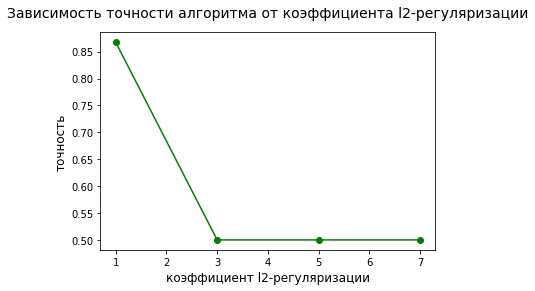

In [176]:
plt.plot(d_l2.keys(), d_l2.values(), 'go', linewidth=3)
plt.plot(d_l2.keys(), d_l2.values(), 'g', linewidth=1.5)
plt.title('Зависимость точности алгоритма от коэффициента l2-регуляризации', pad=15, fontsize=14)
plt.ylabel('точность', fontsize=12)
plt.xlabel('коэффициент l2-регуляризации', fontsize=12);

### 5. Измерение качества и интерпретация результатов (3 балла)
Выберите лучший алгоритм для тестовой выборки. Обратите внимание, что необходимо использовать порог бинаризации, выбранный на отложенной выборке.

In [131]:
lm = LinearModel(BinaryLogisticLoss(l2_opt),  step_alpha=alpha, step_beta=beta)
lm.fit(X['train'], y['train'], trace=True, X_val=X['valid'], y_val=y['valid'])
y_pred = lm.predict(X['test'], lm.get_optimal_threshold(X['valid'], y['valid']))
print(f"Точность на тестовой выборке {round(compute_balanced_accuracy(y['test'], y_pred), 3)}")

Точность на тестовой выборке 0.853


#### Ответьте на следующие вопросы

1. Примените лучший алгоритм к тестовой выборке и посмотрите на метрику качества. Сравните ее с метрикой на валидации. Опишите ваши наблюдения.

    Точность примерно одинаковая. Немного меньше, но достаточно хорошая. Обычно так происходит, если тестовая выборка не в полной мере похожа на обучающую.

2. Проанализируйте ошибки алгоритма. Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки. Наблюдения опишите.

    Логично, что алгоритм ошибается на пустых и очень коротких строках, на невнятном наборе букв, на языке, отличном от английского (можно пробовать сначала детектить язык, и после этого удалять не английский, как вариант, либо тренировать каждый язык отдельно - тогда может не хватить объектов для качественного анализа).


In [149]:
for i, txt in enumerate(test.loc[np.where(y_pred != y['test']), 'preprocessed_text'][:50]):
    print(i, txt[:100])

0 dear god site horrible
1 jews race get mother mention ethiopian jews testing jews proves well fact accept converts
2 
3 balance page one sentence basic definition word huge amount slang profane uses perhaps former extend
4 puwersa ng masa
5 dare vandalize page hms beagle vandalize demon
6 aapn bhtla aanand jhala
7 avg plenty greeks love king stop acting like greeks hate parrot government tells us via media greeks
8 
9 hrthrtdghrsdtghtrsdhtrhdgthjrtgh fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
10 black mamba ponious snake word kills many people king cobra kills many people india
11 j p harris anything say ancre
12 shameless canvass hello diannaa thanks blocking horrible puke translate page get mad total piece gar
13 hell justin
14 buffoon synonyms bozo buffo clown comedian comic fool harlequin humorist idiot jerk jester joker mer
15 wikimania hello chatting right wikimania pleased meet
16 indigenous population low think deserve everything
17 lewd sex china
18 

3. Проинтерпретируйте линейные коэффициенты признаков. Выберите коэффициенты с набиольшим значением и коэффициенты с наименьшим значением. Проанализируйте, каким словам они соответствуют. Согласуются ли ваши наблюдения с вашими ожиданиями от модели?

    Самыми нетоксичными стали слова вежливости, научные слова и технические.
    
    Самыми токсичными, ожидаемо, стали ругательные и обидные слова. Хотя некоторые из этого списка без контекста имеют нейтральный ('get') или даже положительный оттенок ('mother').
    
    Качество модели хорошо отражает полученные результаты.

In [158]:
sorted_words = sorted(zip(tfidf_vectorizer.get_feature_names(), lm.get_weights()[1:]), key=lambda x: x[1])
best = sorted_words[:50]
worst = sorted_words[-50:]

In [159]:
best

[('article', -0.0005903779904407249),
 ('talk', -0.000518238693558803),
 ('please', -0.0003908691959795896),
 ('thanks', -0.00035877003147596307),
 ('page', -0.00033209150268721246),
 ('would', -0.00028280701052881864),
 ('thank', -0.0002463916560047275),
 ('may', -0.00021561262273406273),
 ('see', -0.00021163237283770159),
 ('deletion', -0.0002112318078763224),
 ('wp', -0.0002057194181587121),
 ('section', -0.00020324670671959428),
 ('use', -0.000199587295924131),
 ('articles', -0.0001983496372514384),
 ('also', -0.00019149716104454616),
 ('image', -0.00018974855809749568),
 ('sources', -0.00018363875820278148),
 ('help', -0.00017928442063832272),
 ('discussion', -0.00017674199395982255),
 ('redirect', -0.00017661547469950077),
 ('one', -0.00017489526122449494),
 ('source', -0.00017394740615508367),
 ('edit', -0.00016683832396829063),
 ('utc', -0.00016331733221835502),
 ('could', -0.00016284423177354457),
 ('link', -0.00015083801906794504),
 ('redirect talk', -0.00014655874178020532),

In [160]:
worst

[('fuck fuck', 0.00014937664565862265),
 ('racist', 0.0001528214681914305),
 ('ur', 0.00015300568353507924),
 ('man', 0.00015330045209780595),
 ('fucker', 0.00015394603865327299),
 ('piece shit', 0.00015862068988282095),
 ('get life', 0.0001596261401245933),
 ('damn', 0.0001635366424183577),
 ('dumb', 0.00016402699575794204),
 ('sucks', 0.00016416084971817405),
 ('mother', 0.00016481452866407966),
 ('pathetic', 0.00016774058409035658),
 ('nigger', 0.00016929612588061023),
 ('kill', 0.0001710743122341745),
 ('like', 0.00017520878509931406),
 ('piece', 0.00017718723897718587),
 ('loser', 0.00018490712700183868),
 ('fat', 0.00018518256662324004),
 ('moron', 0.00018536842387857343),
 ('bullshit', 0.0001864072404484089),
 ('dont', 0.00018712756679088274),
 ('little', 0.00018901510730876087),
 ('crap', 0.0001908283012171289),
 ('penis', 0.00019658822992153272),
 ('bastard', 0.00020079662616121207),
 ('shut', 0.00020726565626811335),
 ('fag', 0.00021185877907886657),
 ('die', 0.00022283683201